In [842]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [843]:
import sys
sys.path.insert(0, "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/")
import hyperiax

In [844]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

import pandas as pd
import numpy as np

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import read_topology, TopologyNode
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree, plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.statistics import gelman_rubin
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm

In [845]:
key = PRNGKey(0)

In [846]:
""" from ete3 import Tree

# Define Newick string
string_tree = "(((A:4,B:4):5,(C:5,D:5):4):4,(E:11,((F:7,G:7):2,(H:4,I:4):5):2):2):1;"

# Load the tree
tree = Tree(string_tree)

# Print tree structure
print(tree)

# Show tree visualization
tree.show() """

' from ete3 import Tree\n\n# Define Newick string\nstring_tree = "(((A:4,B:4):5,(C:5,D:5):4):4,(E:11,((F:7,G:7):2,(H:4,I:4):5):2):2):1;"\n\n# Load the tree\ntree = Tree(string_tree)\n\n# Print tree structure\nprint(tree)\n\n# Show tree visualization\ntree.show() '

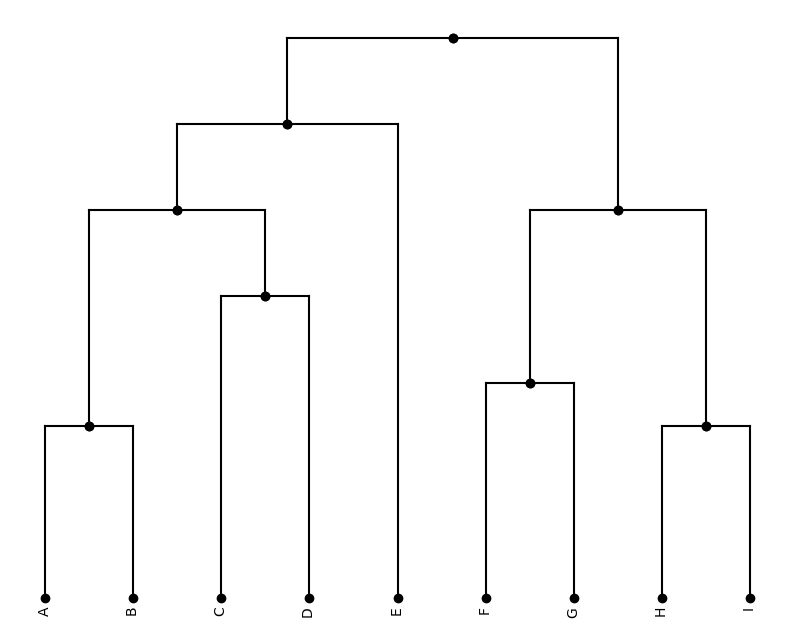

In [847]:
string_tree = "((((A:4,B:4):5,(C:7,D:7):2):2,E:11):2,((F:5,G:5):4,(H:4,I:4):5):4):1;"
tree = read_topology(string_tree)
tree.add_property('value', shape=(4,))
tree.add_property('noise', shape=(4,)) 
key, subkey = split(key)
tree.data['noise'] = jax.random.normal(subkey, shape=tree.data['noise'].shape)
@jax.jit
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length)*noise+parent_value}
tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])
downmodel = DownLambda(down_fn=down)
exe = OrderedExecutor(downmodel)
exe.down(tree)
plot_tree(tree,inc_names=True) 

In [848]:
""" string_tree = "((A:4,B:4)E:5,(C:5,D:5)F:4):1;"
tree = read_topology(string_tree)
plot_tree(tree,inc_names=True)
tree.add_property('value', shape=(2,))
arr = np.array([ [1, 2], [3, 4], [5, 6], [7, 8]])
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(arr[:,:])
leaf_values = tree.data['value'][tree.is_leaf]
print(leaf_values) """


' string_tree = "((A:4,B:4)E:5,(C:5,D:5)F:4):1;"\ntree = read_topology(string_tree)\nplot_tree(tree,inc_names=True)\ntree.add_property(\'value\', shape=(2,))\narr = np.array([ [1, 2], [3, 4], [5, 6], [7, 8]])\ntree.data[\'value\'] = tree.data[\'value\'].at[tree.is_leaf].set(arr[:,:])\nleaf_values = tree.data[\'value\'][tree.is_leaf]\nprint(leaf_values) '

In [849]:
leaf_noise = tree.data['noise'][tree.is_leaf]
leaf_values = tree.data['value'][tree.is_leaf]
inner_noise = tree.data['noise'][tree.is_inner]
inner_values = tree.data['value'][tree.is_inner]

In [850]:
from collections import deque
from typing import Iterator

def iter_topology_leaves_post(self) -> Iterator[TopologyNode]:
    """
    Iterate over all leaf nodes in post-order traversal.
    """
    def post_order(node):
        if not node.children:  # If node has no children, it's a leaf
            yield node
        for child in node.children:
            yield from post_order(child)

    yield from post_order(self.topology_root)

def iter_topology_inner_nodes_post(self) -> Iterator[TopologyNode]:
    """
    Iterate over all inner nodes (excluding the root and leaves) in post-order traversal.
    """
    def post_order(node):
        for child in node.children:
            yield from post_order(child)
        if node.children and node is not self.topology_root:  # Only inner nodes
            yield node

    yield from post_order(self.topology_root)
    
def iter_topology_leaves_inorder(self) -> Iterator[TopologyNode]:
    """
    Iterate over all leaf nodes in in-order traversal.
    """
    def in_order(node):
        if not node:
            return

        if len(node.children) > 0:  # Left child exists
            yield from in_order(node.children[0])

        if not node.children:  # If node has no children, it's a leaf
            yield node

        if len(node.children) > 1:  # Right child exists
            yield from in_order(node.children[1])

    yield from in_order(self.topology_root)


def iter_topology_inner_nodes_inorder(self) -> Iterator[TopologyNode]:
    """
    Iterate over all inner nodes (excluding the root and leaves) in in-order traversal.
    """
    def in_order(node):
        if not node:
            return

        if len(node.children) > 0:  # Left child exists
            yield from in_order(node.children[0])

        if node.children and node is not self.topology_root:  # Only inner nodes (not root or leaves)
            yield node

        if len(node.children) > 1:  # Right child exists
            yield from in_order(node.children[1])

    yield from in_order(self.topology_root)
    
def iter_topology_leaves_bfs(self) -> Iterator[TopologyNode]:
        """
        Iterate over all of the leaves in the tree, in a breadth-first manner.
        """
        queue = deque([self.topology_root])

        while queue:
            current = queue.popleft()
            if current.children:
                queue.extend(current.children)
            else:
                yield current
    
def iter_topology_inner_nodes_bfs(self, exclude_root = True) -> Iterator["TopologyNode"]:
    """
    Iterate over all inner nodes (excluding leaves) in a breadth-first manner.
    """
    queue = deque([self.topology_root])

    while queue:
        current = queue.popleft()
        if current.children:  # Internal nodes have children
            queue.extend(current.children)  # Add children to queue
            if exclude_root: # Exclude root if needed
                if current is not self.topology_root:  
                    yield current  # Yield only non-root inner nodes
            if not exclude_root: 
                yield current
                
def iter_topology_inner_nodes_dfs(self, exclude_root = True) -> Iterator["TopologyNode"]:
    """
    Iterate over all inner nodes (excluding leaves) in a breadth-first manner.
    """
    queue = deque([self.topology_root])

    while queue:
        current = queue.popleft()
        if current.children:  # Internal nodes have children
            queue.extend(reversed(current.children))  # Add children to queue
            if exclude_root: # Exclude root if needed
                if current is not self.topology_root:  
                    yield current  # Yield only non-root inner nodes
            if not exclude_root: 
                yield current



In [851]:
def pylogenic_matrices(tree):

    # Add cumulative edge lengths and level to tree
    tree.add_property('level', shape=(1,))
    tree.add_property('cum_sum_edge_length', shape=(1,))
        
    @jax.jit
    def down(edge_length, parent_cum_sum_edge_length, parent_level, **args):
        return {'cum_sum_edge_length': edge_length + parent_cum_sum_edge_length, 'level' : 1 + parent_level}

    downmodel = DownLambda(down_fn=down)

    exe = OrderedExecutor(downmodel)

    exe.down(tree)

    # Generate C matrix
    
    def find_shared_edge_lengths(a:TopologyNode, b:TopologyNode):
        # If the two nodes are on a different level, move one node a level up
        while tree.data['level'][a.id][0] > tree.data['level'][b.id][0]:
            a = a.parent
        while tree.data['level'][a.id][0] < tree.data['level'][b.id][0]:
            b = b.parent
        # If the nodes are on the same level but don't have the same parent, move both a level up 
        while a.id!=b.id:
            a = a.parent
            b = b.parent
        return tree.data['cum_sum_edge_length'][a.id][0]   
    
    #leaves should be inorder and inner nodes should be postorder to match example from article
    
    leaves = list(iter_topology_leaves_bfs(tree))
    inner_nodes = list(iter_topology_inner_nodes_bfs(tree))
    
    C_Y = np.array([[find_shared_edge_lengths(a, b) for b in leaves] for a in leaves])   
    C_A = np.array([[find_shared_edge_lengths(a, b) for b in inner_nodes] for a in inner_nodes])  
    C_AY = np.array([[find_shared_edge_lengths(a, b) for b in leaves] for a in inner_nodes]) 
    
    return C_Y,C_A,C_AY
                

In [852]:
C_leaves, C_inner, C_leaves_inner = pylogenic_matrices(tree)
print(C_leaves)
print(C_leaves_inner)

[[13.  0.  0.  0.  0.  2.  2.  2.  2.]
 [ 0. 13.  8.  4.  4.  0.  0.  0.  0.]
 [ 0.  8. 13.  4.  4.  0.  0.  0.  0.]
 [ 0.  4.  4. 13.  9.  0.  0.  0.  0.]
 [ 0.  4.  4.  9. 13.  0.  0.  0.  0.]
 [ 2.  0.  0.  0.  0. 13.  9.  4.  4.]
 [ 2.  0.  0.  0.  0.  9. 13.  4.  4.]
 [ 2.  0.  0.  0.  0.  4.  4. 13.  6.]
 [ 2.  0.  0.  0.  0.  4.  4.  6. 13.]]
[[2. 0. 0. 0. 0. 2. 2. 2. 2.]
 [0. 4. 4. 4. 4. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 4. 4. 4. 4.]
 [0. 8. 8. 4. 4. 0. 0. 0. 0.]
 [0. 4. 4. 9. 9. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 9. 9. 4. 4.]
 [2. 0. 0. 0. 0. 4. 4. 6. 6.]]


In [ ]:
import plotly.express as px

def phylo_PCA(C_Y, Y):
    # Get phylogenetic covariance matrix
    n = C_Y.shape[0]
    # Get estimated ancestral root
    # a = [(1^T · C^{-1} · 1)^{-1} · 1^T · C^{-1} · X]^T
    ones = np.ones((n,1))
    a = (np.linalg.inv(ones.T@np.linalg.inv(C_Y)@ones)@ones.T@np.linalg.inv(C_Y)@Y).T
    # Get evolutionary covariance matrix
    # Pp = (n − 1)^{-1} · (X − a^T)^T · C^{-1} · (X − a^T)
    data_cent = (Y - a.T)
    P = (1 / (n-1)) * data_cent.T @ np.linalg.inv(C_Y) @ data_cent
    # Extract eigenvalues and eigenvectors with SVD
    Up, Sp, Vh = np.linalg.svd(P)
    return Up, Sp, a

def _PCA(data):
    # P = (n − 1)^{-1} · (X − mean[X])^T · (X − mean[X])
    mean = np.mean(data, axis=0)
    data_cent = (data - mean)
    #cov_matrix = np.cov(data_cent, rowvar=False)
    # Extract eigenvalues and eigenvectors
    U, S, Vh = np.linalg.svd(data_cent)
    return U, S, mean

In [854]:
def transform_data(features_leaves, features_inner, PCevecs, a, dims):
    # Sp = (X-a) · Up
    # Ensure a has the correct shape
    a = a.reshape(1, -1)
    # Center the data
    centered_leaves = features_leaves - a
    centered_inner = features_inner - a
    # Project onto principal component space
    transformed_leaves = centered_leaves @ PCevecs[:, :dims]
    transformed_inner = centered_inner @ PCevecs[:, :dims]
    return transformed_leaves, transformed_inner

In [855]:
def estimate_ancestral_nodes(C_AY, C_Y, Y):
    return (C_AY @ np.linalg.inv(C_Y) @ Y)

#def estimate_ancestral_nodes(C_AY, C_Y, Y):
#    # Compute the inverse of the covariance matrix product
#    C_Y_inv = np.linalg.inv(C_Y)
#    # Estimate the ancestral nodes
#    a = np.linalg.inv(C_AY.T @ C_Y_inv @ C_AY) @ (C_AY.T @ C_Y_inv @ Y)
#    return a

In [856]:
estimated_inner = estimate_ancestral_nodes(C_leaves_inner, C_leaves, leaf_values)


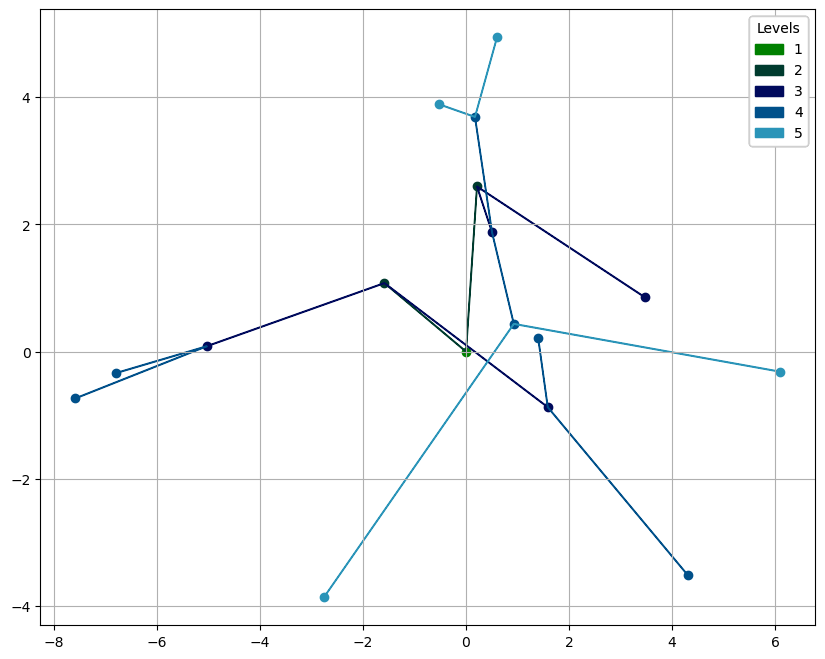

In [857]:
Ppevecs, Ppevals, a = phylo_PCA(C_leaves, leaf_values)
features_leaves, features_inner = transform_data(leaf_values, estimated_inner, Ppevecs, a, 2)

tree.add_property('projected_value', shape=(2,))
    
tree.data['projected_value'] = tree.data['projected_value'].at[tree.is_leaf].set(features_leaves)
tree.data['projected_value'] = tree.data['projected_value'].at[tree.is_inner].set(features_inner)

plot_tree_2d_scatter(tree, 'projected_value')


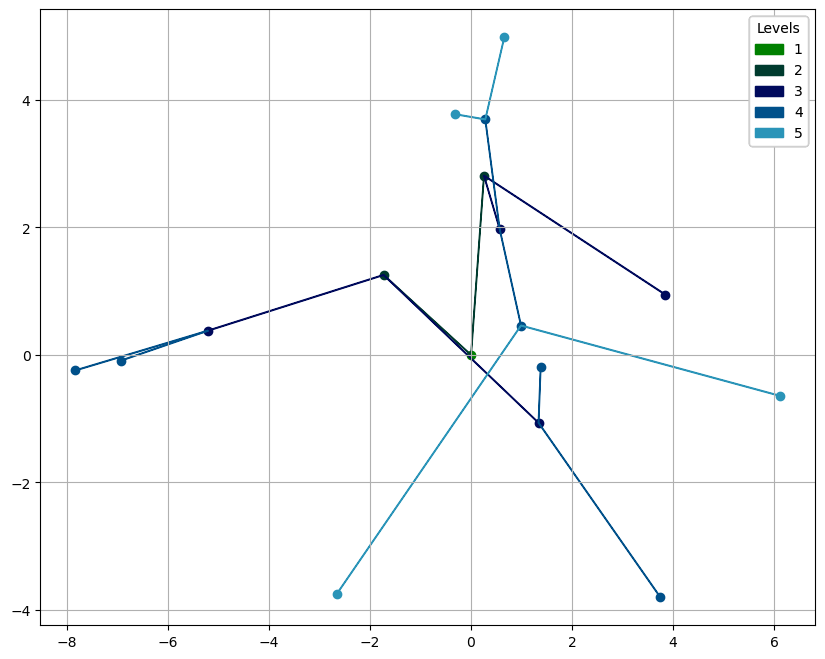

In [858]:
Pevecs, Pevals, mean = _PCA(leaf_values)
features_leaves_normal, features_inner_normal = transform_data(leaf_values, estimated_inner, Pevecs, a, 2)

features_leaves_normal = features_leaves_normal.at[:, 1].multiply(-1)
features_inner_normal = features_inner_normal.at[:, 1].multiply(-1)

tree.add_property('projected_value_normal_pca', shape=(2,))
    
tree.data['projected_value_normal_pca'] = tree.data['projected_value_normal_pca'].at[tree.is_leaf].set(features_leaves_normal)
tree.data['projected_value_normal_pca'] = tree.data['projected_value_normal_pca'].at[tree.is_inner].set(features_inner_normal)

plot_tree_2d_scatter(tree, 'projected_value_normal_pca')


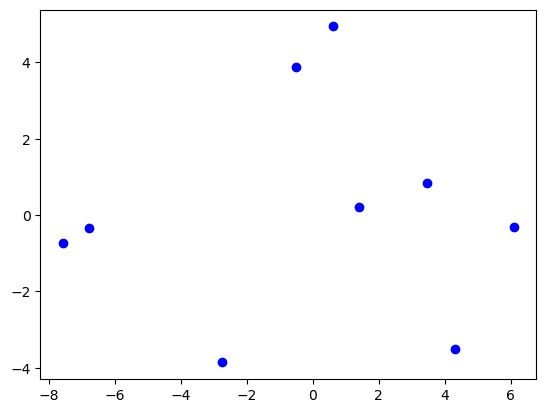

In [859]:
plt.scatter(features_leaves[:, 0], features_leaves[:, 1], label="PCA Features", color="blue", marker="o")

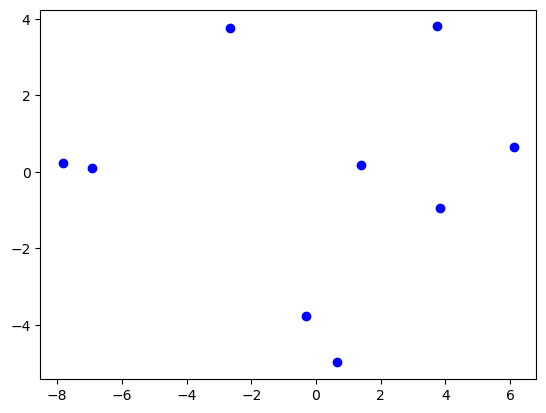

In [860]:
plt.scatter(features_leaves_normal[:, 0], -features_leaves_normal[:, 1], label="PCA Features", color="blue", marker="o")

In [3]:
from sklearn.decomposition import PCA

# Generate random leaf trait data
np.random.seed(42)
Y_random = np.random.randn(10, 5)  # 10 leaves, 5 traits

# Use identity covariance (no phylogenetic structure)
C_Y_identity = np.eye(10)

# Run pPCA
Up_ppca, Sp_ppca, a_ppca = phylo_PCA(C_Y_identity, Y_random)

# Run standard PCA
U_pca, S_pca, mean_pca = _PCA(Y_random)

# Run sklearn PCA
pca = PCA()
pca.fit(Y_random)

# Compare eigenvalues
print("pPCA Eigenvalues:", Sp_ppca)
print("Standard PCA Eigenvalues:", S_pca)
print("Sklean PCA Eigenvalues:", pca.singular_values_)

# Compare eigenvectors (up to sign flips)
print("pPCA Eigenvectors:\n", Up_ppca)
print("Standard PCA Eigenvectors:\n", U_pca)
print("Sklean PCA Eigenvectors:\n", pca.components_.T)

NameError: name 'np' is not defined